In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Import ancillary libraries

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

In [3]:
# use the command to install keras 
!pip install -q  keras

In [4]:
# import libraries
import keras
import os
import glob

The aim of the project to detect pneumonia disease using deep learning convolutional neural network(cnn). The chest-xray dataset images are collected from kaggle competition website labled as pnuemonia and normal.

### Import Deep Learning Libraries

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten , Conv2D 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import warnings
from tensorflow.keras.layers import MaxPooling2D, Flatten,  Dropout, Activation
from tensorflow.keras.optimizers import Adam, RMSprop, SGD


## Define the paths for training, testing and validation directories¶

In [6]:
# Define paths to directory and file locations
train_path = "/content/gdrive/MyDrive/Colab Notebooks/chest_xray/train"
test_path = "/content/gdrive/MyDrive/Colab Notebooks/chest_xray/test"
val_path = "/content/gdrive/MyDrive/Colab Notebooks/chest_xray/val"

### Input Size

In [7]:
# input image size
IMAGE_SIZE = 224
BATCH_SIZE = 32

## Creat image data generator

In [8]:
# Rescale the image size by multiplying the pexil by 1.0/255

traingen = ImageDataGenerator(rescale = 1/255,
                 zoom_range = 0.2,
                 width_shift_range = 0.2,
                 height_shift_range = 0.2,
                 fill_mode = "nearest",
                )
valgen = ImageDataGenerator(rescale = 1/255,
                 zoom_range = 0.2,
                 width_shift_range = 0.2,
                 height_shift_range = 0.2,
                 fill_mode = "nearest",
                )

testgen = ImageDataGenerator(rescale = 1/255,)

### Subset the dataset into training, validation and test classes

In [9]:
# set the training dataset to have the specified parameters
train_ds = traingen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        seed = 123,
                                        batch_size=BATCH_SIZE,
                                        class_mode = "binary"
                                       )

val_ds  = valgen.flow_from_directory(val_path,
                                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                      seed = 123,
                                      batch_size=8,
                                      class_mode = "binary"
                                     )

test_ds = testgen.flow_from_directory(test_path, 
                                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                      seed = 123,
                                      batch_size=BATCH_SIZE,
                                      shuffle = False,
                                      class_mode = "binary"
                                      )

Found 5225 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
total_images = []
lst = [train_ds, test_ds, val_ds]
for i in lst:
    total_images.append(i)
print(len(total_images))
train_ds1, test_ds2, val_ds3 = [],[],[]
for j in range(len(total_images)):
    if j % 5== 0:
       test_ds2.append(total_images[j])
    elif j % 9 == 0:
         val_ds3.append(total_images[j])
    else:
        train_ds1.append(total_images[j])

print(len(train_ds1))
       

3
2


In [11]:
# using  class_indices method on generated data gives dictionary keys and values. 
class_names = train_ds.class_indices
print(class_names)
class_names = list(class_names.keys())
print(class_names)

{'NORMAL': 0, 'PNEUMONIA': 1}
['NORMAL', 'PNEUMONIA']


## Collect the number of images belongs to the classes

In [12]:
DIR = "/content/gdrive/MyDrive/Colab Notebooks/chest_xray/"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for subset in sets:
    path = os.path.join(DIR, subset)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)
print("<<"*20)
print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")
print("<<"*20)

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Total Pneumonia Images: 4273
Total Normal Images: 1592
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


## Data Visualization

In [13]:
# classes method return to which class the datapoint is belogs.
class_distribution = train_ds.classes
class_distribution

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

Text(0.5, 1.0, 'Training Dataset Distribution Plot')

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  func(*args, **kwargs)


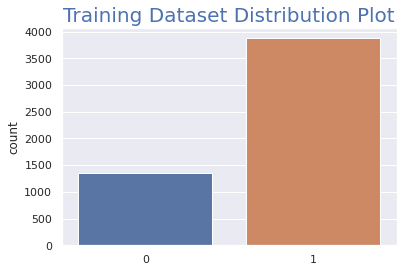

In [14]:
# Using countplot collect the number of classe's value 
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.countplot(x=class_distribution)
plt.title("Training Dataset Distribution Plot", size = 20, color='B')




From the distribution plot above there is a data imbalance between the two classes.

In [15]:
# train_ds is a generator thus apply next to get the value from  iterable generator 

images_batch, label_batch = next(iter(train_ds))



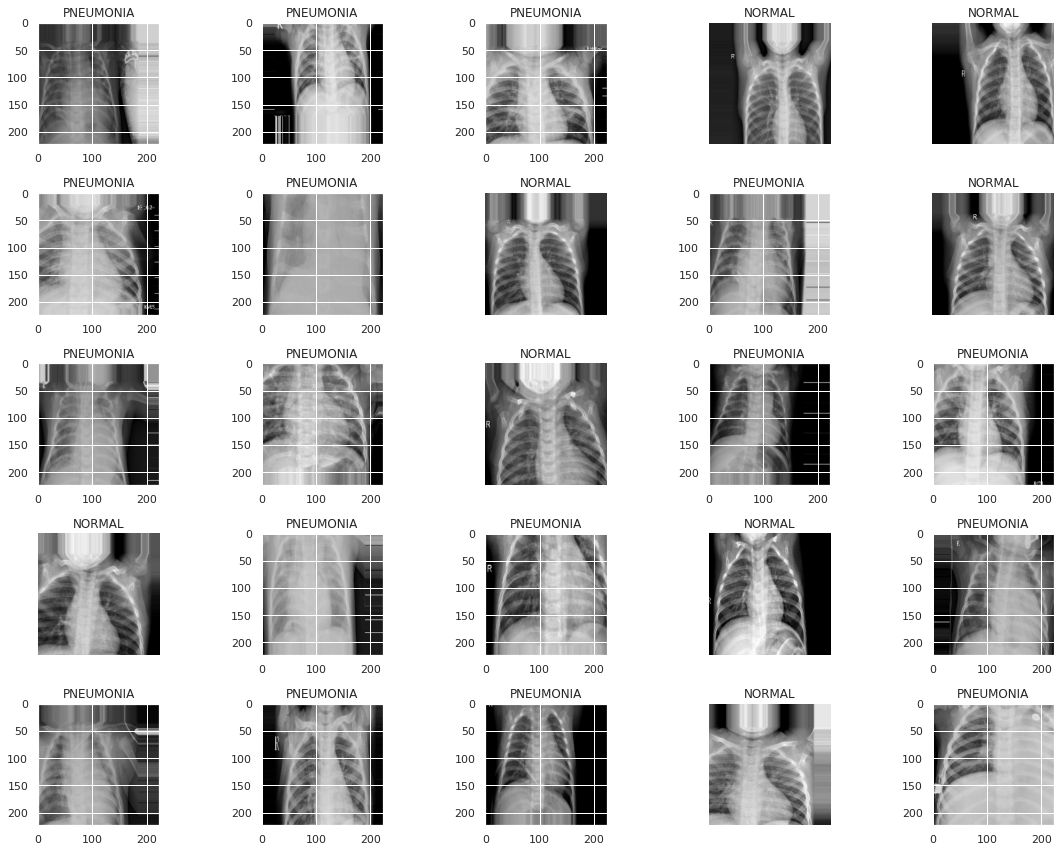

In [16]:
# Define the function to inspect few of the images.
def show_batch(images_batch, label_batch):
    """ Funcation take both the  images_batch  and label_batch as parameters generted from next(iter(train_ds)"""
    plt.figure(figsize=(16,12))
    # loop through over the firest 25 images
    for i in range(0, 25):
        ax= plt.subplot(5, 5, i+1)
        plt.imshow(images_batch[i])
        #if label_batch[i] is true or equals to boolean one label it as Pneumonia otherwise label it as Normal
        if label_batch[i]:
            plt.title("PNEUMONIA")
        else:
            plt.title('NORMAL')
            plt.axis('off')
    # Use plt.tight_layout to avoid overlap between the colomns 
    plt.tight_layout()
show_batch(images_batch, label_batch)

In [17]:
# Input shape width, height and lumber of channels or RBG
train_ds.image_shape

(224, 224, 3)

In [18]:
# apply class_indices param to see the dictionary(keys and values)
train_ds.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Convolution Neural Network Deep Learing  Modeling

In [19]:
# input shape fed to first layer of the cnn
input_shape = train_ds.image_shape 
# using Sequential method connect the layers 
model = Sequential()
# apply Conv2D and relu activation to filter pixes with 0 and above values.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
# Filter the data further by taking the maximum value of pixles from 2 by 2 blocks
model.add(MaxPooling2D(pool_size=(2, 2)))
# repeat the same steps until the desired pexiles remain.
model.add(Conv2D(32, (3, 3),  activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Flatten the networked multilayer values into a single layer
model.add(Flatten())

model.add(Dense(64, activation="relu"))

model.add(Dropout(0.5))

model.add(Dense(1))
# Sigmoid function classify the result either the image is Normal or has Pnuemonia symptom.
model.add(Activation('sigmoid'))

### Compile the Model

In [20]:
# compile all the relevant metrics result from the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [21]:
# Create Input Shape
input_shape = (None,224,224,3)

In [22]:
# build the model and pass the input shape
model.build(input_shape)

In [23]:
# Inspect the summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [24]:
# Train the model, fitting both the training and test datasets, number of epochs etc.
training = model.fit(
        train_ds,
        validation_data= val_ds,
        steps_per_epoch=60,
        epochs=20)

Epoch 1/20
60/60 [==============================] - 53s 839ms/step - loss: 0.5365 - accuracy: 0.7146 - val_loss: 2.9485 - val_accuracy: 0.5625
Epoch 2/20
60/60 [==============================] - 51s 837ms/step - loss: 0.3999 - accuracy: 0.7698 - val_loss: 3.5064 - val_accuracy: 0.5625
Epoch 3/20
60/60 [==============================] - 49s 822ms/step - loss: 0.3831 - accuracy: 0.8355 - val_loss: 2.0548 - val_accuracy: 0.5625
Epoch 4/20
60/60 [==============================] - 48s 809ms/step - loss: 0.3633 - accuracy: 0.8401 - val_loss: 1.8250 - val_accuracy: 0.5625
Epoch 5/20
60/60 [==============================] - 47s 784ms/step - loss: 0.3228 - accuracy: 0.8453 - val_loss: 2.8550 - val_accuracy: 0.6250
Epoch 6/20
60/60 [==============================] - 49s 810ms/step - loss: 0.3323 - accuracy: 0.8526 - val_loss: 1.9064 - val_accuracy: 0.5625
Epoch 7/20
60/60 [==============================] - 47s 782ms/step - loss: 0.3189 - accuracy: 0.8566 - val_loss: 0.7711 - val_accuracy: 0.6875

In [25]:
model.evaluate(test_ds)

20/20 [==============================] - 141s 7s/step - loss: 0.5246 - accuracy: 0.8333


[0.5246434211730957, 0.8333333134651184]

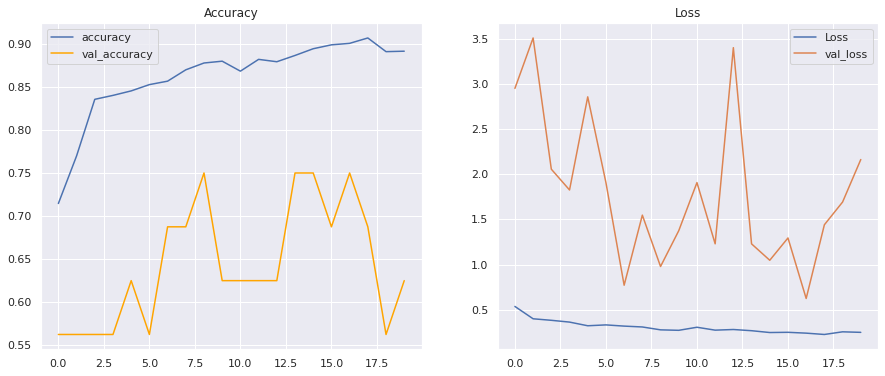

In [26]:
# Plot the accuracy from training and validation data
history = training.history
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], color='b')
plt.plot(history['val_accuracy'], color = 'orange')

plt.title('Accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc='best')
# plot the loss from the training and validation data
plt.subplot(1,2,2)
plt.plot( history['loss'])
plt.plot( history['val_loss'])

plt.title("Loss")
plt.legend(['Loss', 'val_loss'], loc='best')
plt.show()

In [27]:
pred = model.predict(test_ds)

In [28]:
#pred

In [29]:
predicted = []
for  prob in pred:
  if prob  < 0.5:
    predicted.append(0)
  else:
    predicted.append(1)


In [30]:
# The true predicted value is the same of the test dataset values 
y_true = test_ds.classes


In [31]:
# Check the dimension
len(y_true)

624

In [32]:
# Apply confusion metrix to compare how much of the predicted identified correctly
cm =confusion_matrix(y_true, predicted)

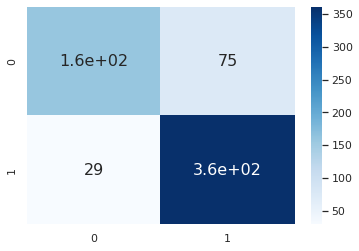

In [33]:
# seaborn heatmap to visualize the confusion matrix plot
sn.heatmap(cm,  annot=True, cmap="Blues", annot_kws={'size':16})


In [34]:
print(classification_report(y_true, predicted))

              precision    recall  f1-score   support

           0       0.85      0.68      0.75       234
           1       0.83      0.93      0.87       390

    accuracy                           0.83       624
   macro avg       0.84      0.80      0.81       624
weighted avg       0.83      0.83      0.83       624



### Summary

The most relevant aspect of this modeling is how much of the people who are labeled as pneumonia are accurately classified that defined by recall or sensitivity parameter. Based on the recall parameter, 96% of the patients were identified as having pneumonia. The accuracy score from the imbalance date is not reliable thus, the choice of F score relay on the desired target. F score is the harmonic mean of precision and recall. Since this project target to improve the score of recall than precision, choosing the right beta value is imperative. F score with beta = 3, return the highest score. 

The dataset shows data imbalance between NORMAL and PNEUMONIA images.
The data imbalance will result in bias outcomes and model overfitting. Data augmentation was implemented in increasing the data from the existed data using various augmentation techniques. This technique minimizes the effect of data imbalance on the model performance.

In [57]:
# Use data augmentation to propagate thw number of data from the existing dataset using Random Flip and Random rotation
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])

## Create the model

In [39]:
# input shape fed to first layer of the cnn
input_shape = train_ds.image_shape 
# using Sequential method connect the layers 
model_1 = Sequential()
model_1.add(data_augmentation)
# apply Conv2D and relu activation to filter pixes with 0 and above values.
model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
# Filter the data further by taking the maximum value of pixles from 2 by 2 blocks
model_1.add(MaxPooling2D(pool_size=(2, 2)))
# repeat the same steps until the desired pexiles remain.
model_1.add(Conv2D(32, (3, 3),  activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
#Flatten the networked multilayer values into a single layer
model_1.add(Flatten())

model_1.add(Dense(64, activation="relu"))

model_1.add(Dropout(0.5))

model_1.add(Dense(1))
# Sigmoid function classify the result either the image is Normal or has Pnuemonia symptom.
model_1.add(Activation('sigmoid'))

## Compile the Model

In [58]:
# compile all the relevant metrics result from the model
model_1.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [59]:
# Create Input Shape
input_shape = (None,224,224,3)

In [60]:
# build the model and pass the input shape
model_1.build(input_shape)

In [61]:
# Inspect the summary
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, None, None, None)  0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 32)    896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 64)    18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, None, None, 64)   

## Train the Model

In [62]:
# Fit and Training the dataset using train_ds, val_ds
training = model_1.fit(
        train_ds,
        validation_data= val_ds,
        epochs=20)

Epoch 1/20
164/164 [==============================] - 137s 829ms/step - loss: 0.5318 - accuracy: 0.7401 - val_loss: 0.8644 - val_accuracy: 0.6250
Epoch 2/20
164/164 [==============================] - 135s 822ms/step - loss: 0.4254 - accuracy: 0.7755 - val_loss: 1.3692 - val_accuracy: 0.5625
Epoch 3/20
164/164 [==============================] - 134s 814ms/step - loss: 0.3833 - accuracy: 0.8214 - val_loss: 4.7132 - val_accuracy: 0.6250
Epoch 4/20
164/164 [==============================] - 134s 818ms/step - loss: 0.3900 - accuracy: 0.8310 - val_loss: 2.4017 - val_accuracy: 0.5000
Epoch 5/20
164/164 [==============================] - 135s 824ms/step - loss: 0.3677 - accuracy: 0.8488 - val_loss: 1.7196 - val_accuracy: 0.6250
Epoch 6/20
164/164 [==============================] - 136s 826ms/step - loss: 0.3366 - accuracy: 0.8559 - val_loss: 2.1798 - val_accuracy: 0.5000
Epoch 7/20
164/164 [==============================] - 135s 820ms/step - loss: 0.3239 - accuracy: 0.8632 - val_loss: 1.5715 -

# Modle performance after data augmentation 

In [64]:
model_1.evaluate(test_ds)

20/20 [==============================] - 7s 338ms/step - loss: 0.3705 - accuracy: 0.8622


[0.37052121758461, 0.8621794581413269]

## Summary: 
Data augmentation technique rose model performance from 0.833 to 0.862. The 3% accuracy improvement is significant and reflects the sound contribution. 